In [ ]:
# Cell 1
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
# Cell 2
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

In [ ]:
# Cell 3
model_builder = ResNet152
img_size = (224, 224) # ResNet152 expects this input size
preprocess_input = tf.keras.applications.resnet.preprocess_input
decode_predictions = tf.keras.applications.resnet.decode_predictions

last_conv_layer_name = "conv5_block3_out"  # Last convolutional layer in ResNet152


In [ ]:
# Cell 4
def get_img_array(img_path, size=(224, 224)): # Update size to (224, 224)
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
# Cell 5
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Top prediction
        class_channel = preds[0][pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
# Cell 6
model = ResNet152(weights='imagenet')

242900224/242900224 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Cell 7
# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Cell 8
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display the Grad-CAM image
    plt.figure(figsize=(6, 8))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()


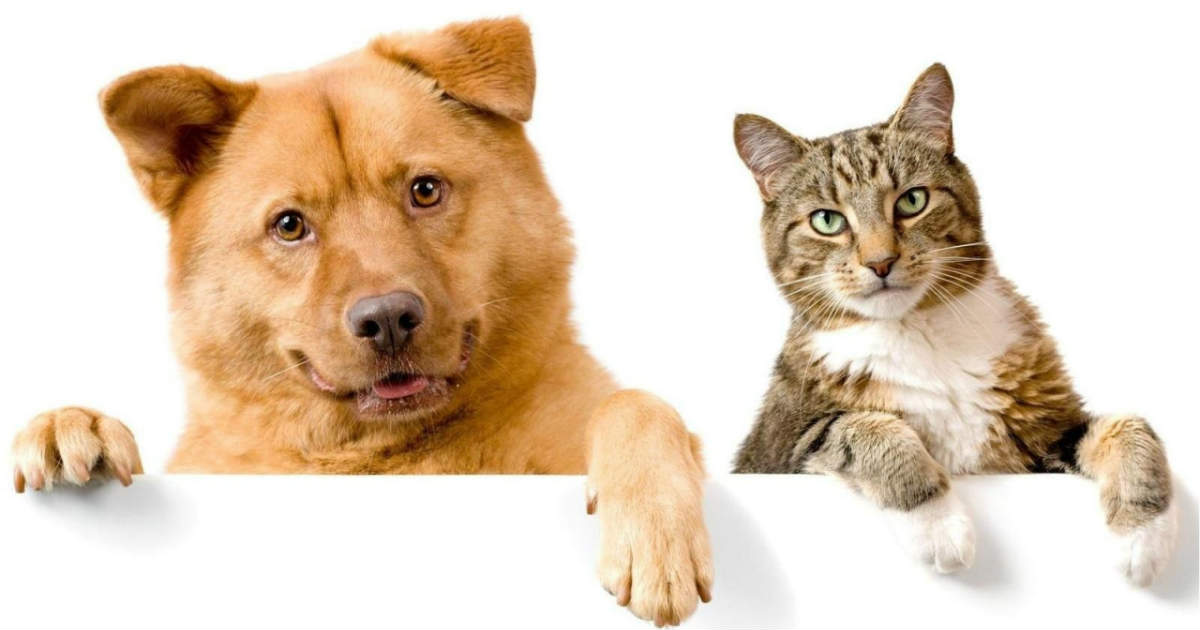

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
Predicted: [('n02106662', 'German_shepherd', 7.7796702), ('n04493381', 'tub', 7.3526506)]


In [ ]:
# Cell 9
img_path ="dq.jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

# Dog Class

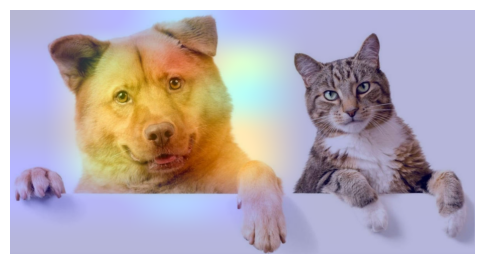

In [ ]:
# Cell 10
#We generate class activation heatmap for "dog," the class index is 260
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

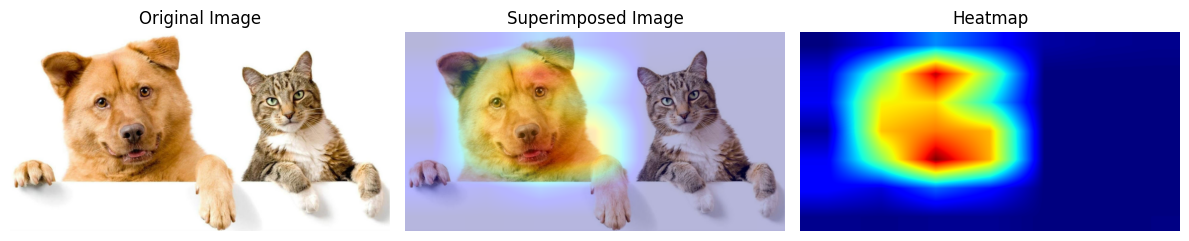

In [ ]:
# Cell 11
import cv2  # Ensure OpenCV is imported

def display_all_images(img_path, heatmap):
    # Load original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rescaled = np.uint8(255 * heatmap_resized)

    # Apply colormap for Grad-CAM
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]  # Get RGB values
    jet_heatmap = jet_colors[heatmap_rescaled]  # Map heatmap to jet colors

    # Convert to image
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Ensure saliency map is also resized to original image size
    saliency_map_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Match original image size
    saliency_map_rescaled = np.uint8(255 * saliency_map_resized)

    # Apply colormap for saliency map
    jet_saliency = jet_colors[saliency_map_rescaled]  # Map heatmap to jet colors
    jet_saliency_img = keras.utils.array_to_img(jet_saliency)

    # Display all images side by side
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(keras.utils.array_to_img(img))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(superimposed_img)
    axes[1].set_title("Superimposed Image")
    axes[1].axis("off")

    axes[2].imshow(jet_saliency_img)
    axes[2].set_title("Heatmap")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function to display all images
display_all_images(img_path, heatmap)


# Rotation Transformation

In [ ]:
# Cell 12
import os
import numpy as np
from scipy.ndimage import rotate
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

def rotate_image(img_path, angle, save_dir="rotated_images"):
    # Load and convert image
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Rotate image (keeping the size unchanged)
    rotated_array = rotate(img_array, angle, reshape=False)

    # Convert back to image
    rotated_img = array_to_img(rotated_array)

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save rotated image
    save_path = os.path.join(save_dir, f"rotated_{angle}.jpg")
    rotated_img.save(save_path)

    return rotated_img, save_path  # Return rotated image and its saved file path


In [ ]:
# Cell 13
rotation_angles = np.arange(-180, 181, 30)  # Angles from -180° to 180° in steps of 30°
rotated_images = []  # List to store (angle, rotated image, rotated path)

# Rotate image for each angle and save it
for angle in rotation_angles:
    rotated_img, rotated_img_path = rotate_image(img_path, angle)
    rotated_images.append((angle, rotated_img, rotated_img_path))

print(f"Generated {len(rotated_images)} rotated images.")


Generated 13 rotated images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


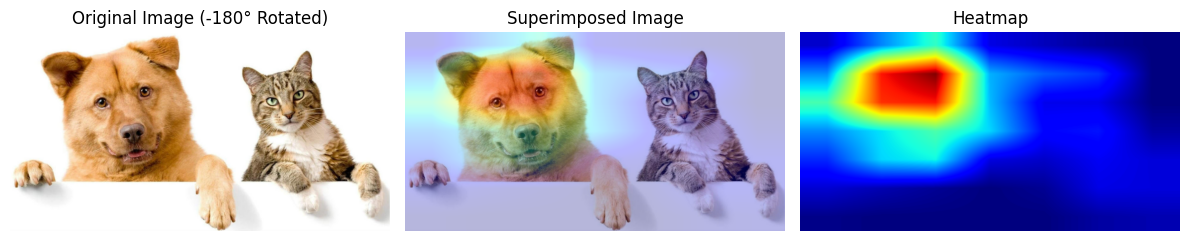

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


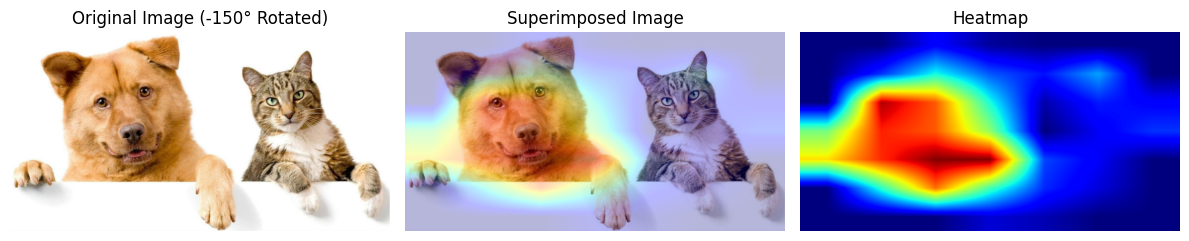

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


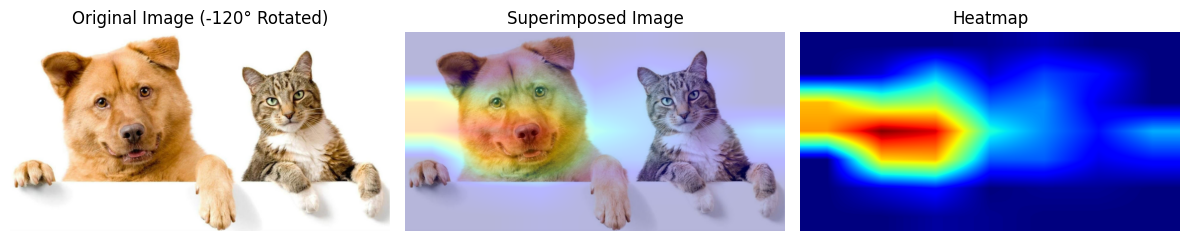

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


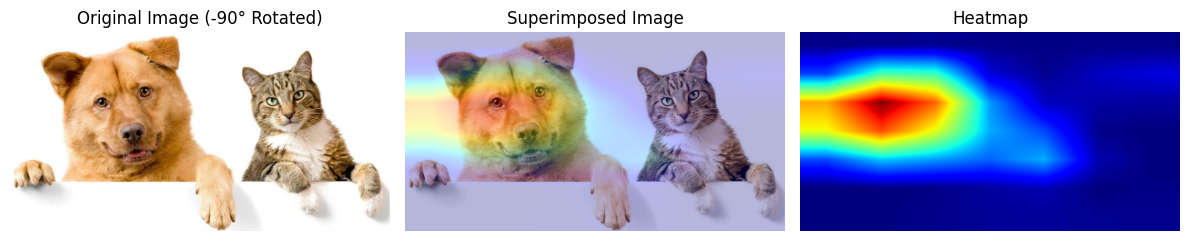

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


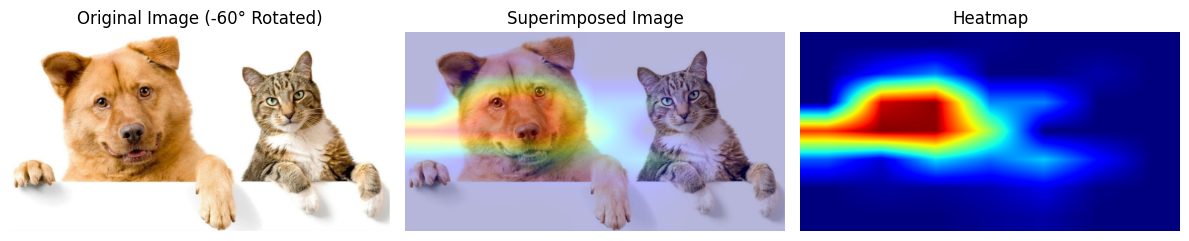

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


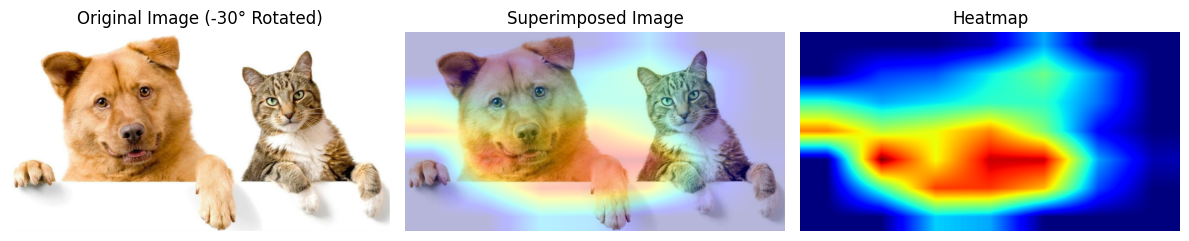

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


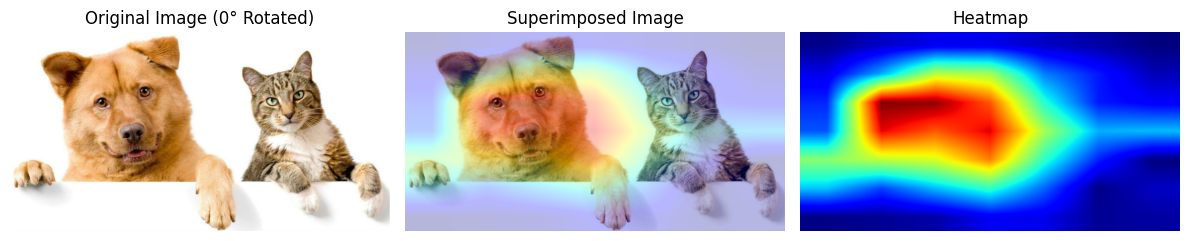

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


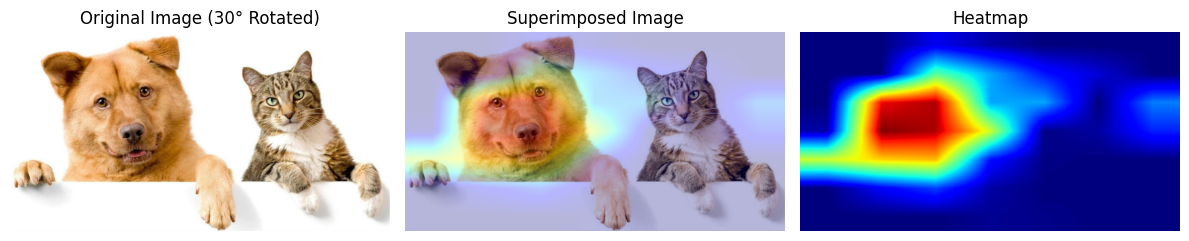

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


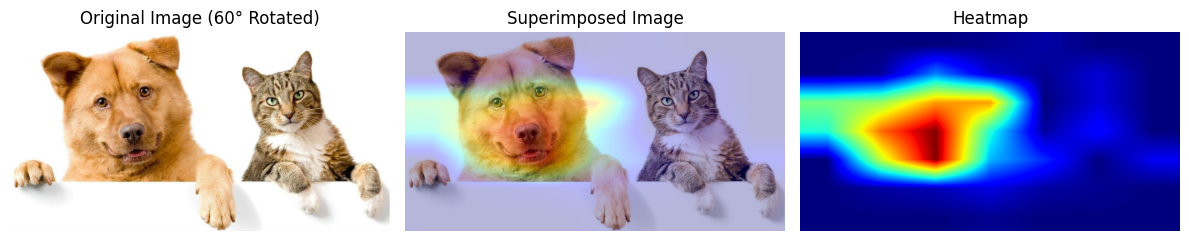

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


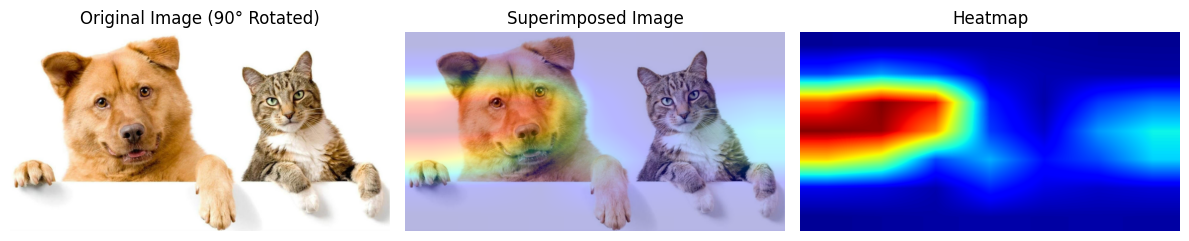

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


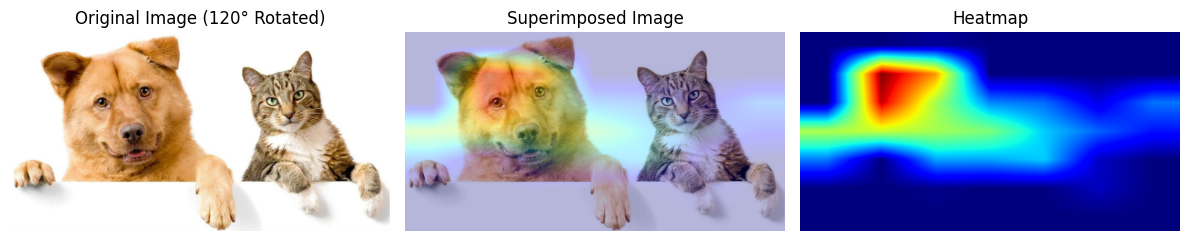

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


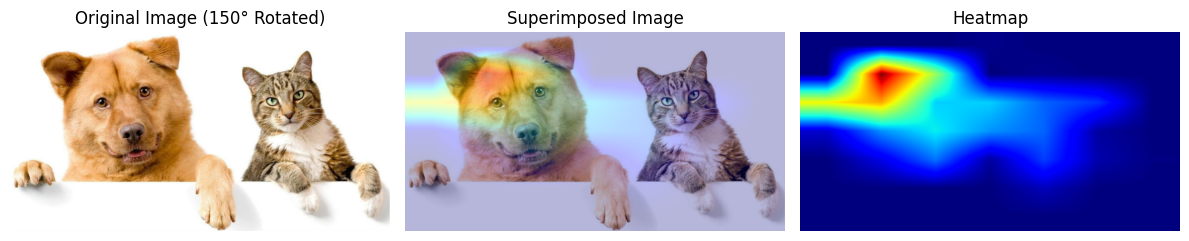

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


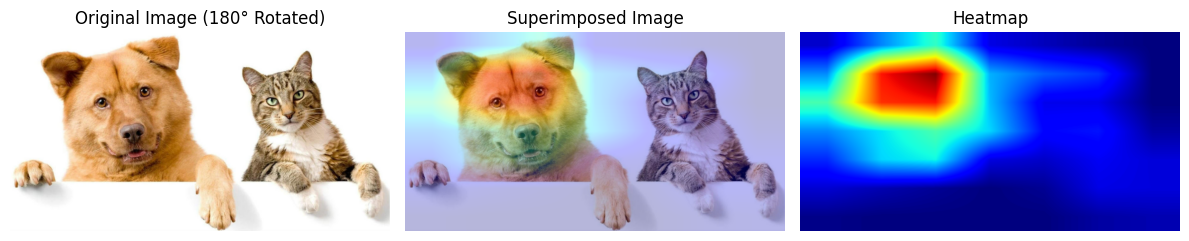

In [ ]:
# Cell 14
import cv2
from scipy.ndimage import rotate as scipy_rotate, gaussian_filter

def display_all_rotated_images(rotated_images):
    for angle, _, rotated_img_path in rotated_images:
        # Load and preprocess the rotated image
        rotated_img_array = preprocess_input(get_img_array(rotated_img_path, size=img_size))

        # Generate predictions
        preds = model.predict(rotated_img_array)
        pred_class = np.argmax(preds[0])  # Get predicted class

        # Generate Grad-CAM heatmap for the predicted class
        heatmap = make_gradcam_heatmap(rotated_img_array, model, last_conv_layer_name, pred_index=pred_class)

        # Rotate the heatmap back to align with the original image
        aligned_heatmap = scipy_rotate(heatmap, -angle, reshape=False, order=0)  # Nearest-neighbor interpolation

        # Clip and normalize the heatmap
        aligned_heatmap = np.maximum(aligned_heatmap, 0)  # Remove negative values
        aligned_heatmap /= np.max(aligned_heatmap) if np.max(aligned_heatmap) > 0 else 1  # Normalize

        # Load original image
        img = keras.utils.load_img(img_path)
        img = keras.utils.img_to_array(img)

        # Resize heatmap to match image size
        heatmap_resized = cv2.resize(aligned_heatmap, (img.shape[1], img.shape[0]))
        heatmap_rescaled = np.uint8(255 * heatmap_resized)

        # Apply colormap for Grad-CAM
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]  # Get RGB values
        jet_heatmap = jet_colors[heatmap_rescaled]  # Map heatmap to jet colors

        # Convert to image
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        # Superimpose heatmap on original image
        superimposed_img = jet_heatmap * 0.4 + img
        superimposed_img = keras.utils.array_to_img(superimposed_img)

        # Ensure saliency map is also resized to original image size
        saliency_map_resized = cv2.resize(aligned_heatmap, (img.shape[1], img.shape[0]))  # Match original image size
        saliency_map_rescaled = np.uint8(255 * saliency_map_resized)

        # Apply colormap for saliency map
        jet_saliency = jet_colors[saliency_map_rescaled]  # Map heatmap to jet colors
        jet_saliency_img = keras.utils.array_to_img(jet_saliency)

        # Display all images side by side
        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(keras.utils.array_to_img(img))
        axes[0].set_title(f"Original Image ({angle}° Rotated)")
        axes[0].axis("off")

        axes[1].imshow(superimposed_img)
        axes[1].set_title("Superimposed Image")
        axes[1].axis("off")

        axes[2].imshow(jet_saliency_img)
        axes[2].set_title("Heatmap")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Call function to display all rotated images with heatmaps
display_all_rotated_images(rotated_images)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


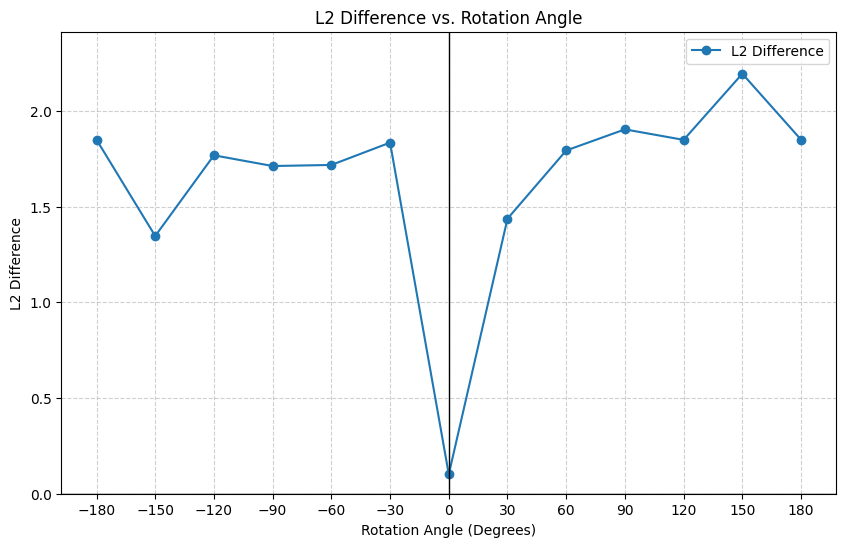

In [ ]:
# Cell 15
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Take the original heatmap (0-degree rotation) as the baseline
original_heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=235)  # Horig

# Step 2 & 3: Compute L2 Difference for each rotated heatmap
l2_differences = []
angles = []

for angle, _, rotated_img_path in rotated_images:
    # Load and preprocess the rotated image
    rotated_img_array = preprocess_input(get_img_array(rotated_img_path, size=img_size))

    # Generate Grad-CAM heatmap for the predicted class
    preds = model.predict(rotated_img_array)
    pred_class = np.argmax(preds[0])  # Get predicted class
    rotated_heatmap = make_gradcam_heatmap(rotated_img_array, model, last_conv_layer_name, pred_index=pred_class)

    # Align rotated heatmap back to original orientation
    aligned_heatmap = scipy_rotate(rotated_heatmap, -angle, reshape=False, order=0)

    # Compute L2 difference (Euclidean distance)
    l2_diff = np.linalg.norm(original_heatmap - aligned_heatmap)
    l2_differences.append(l2_diff)
    angles.append(angle)




# Step 5: Visualize Results - L2 Difference vs Rotation Angle
plt.figure(figsize=(10, 6))
plt.plot(angles, l2_differences, marker='o', linestyle='-', label='L2 Difference')



# Fix X-axis to be centered at 0 and Y-axis starting from zero
plt.xlabel("Rotation Angle (Degrees)")
plt.ylabel("L2 Difference")
plt.title("L2 Difference vs. Rotation Angle")
plt.xticks(np.arange(min(angles), max(angles)+1, 30))  # Keep angles consistent
#plt.yticks(np.linspace(0, max(l2_differences) * 1.1, 10))  # Ensure Y-axis starts at 0
plt.ylim(0, max(l2_differences) * 1.1)  # Ensure Y-axis starts at 0
plt.axhline(y=0, color='black', linewidth=1)  # Ground Y-axis at 0
plt.axvline(x=0, color='black', linewidth=1)  # Ground X-axis at 0
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


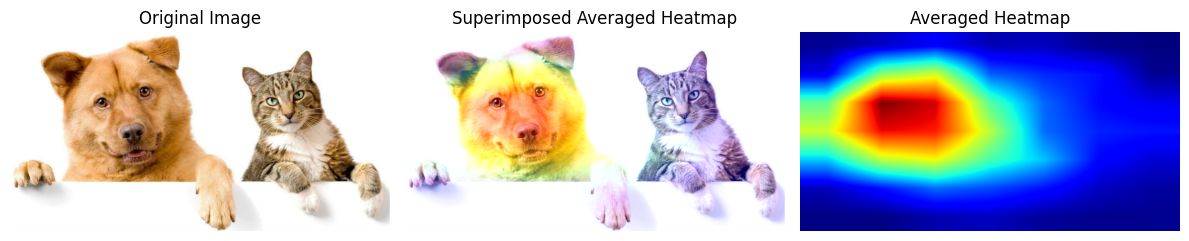

In [ ]:
# Cell 16
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from scipy.ndimage import rotate as scipy_rotate

def average_heatmaps_and_apply(rotated_images, img_path):
    # Load original image
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Initialize accumulator for heatmaps (same size as input image)
    heatmap_accum = np.zeros((img_size[0], img_size[1]), dtype=np.float32)

    count = 0  # Track number of heatmaps

    for angle, _, rotated_img_path in rotated_images:
        # Load and preprocess rotated image
        rotated_img_array = preprocess_input(get_img_array(rotated_img_path, size=img_size))

        # Generate predictions
        preds = model.predict(rotated_img_array)
        pred_class = np.argmax(preds[0])  # Get predicted class

        # Generate Grad-CAM heatmap (small size, e.g., 7x7)
        heatmap = make_gradcam_heatmap(rotated_img_array, model, last_conv_layer_name, pred_index=pred_class)

        # Rotate heatmap back to align with the original image
        aligned_heatmap = scipy_rotate(heatmap, -angle, reshape=False, order=0)

        # **Fix: Resize heatmap to match (224, 224)**
        aligned_heatmap_resized = cv2.resize(aligned_heatmap, (img_size[1], img_size[0]))

        # Normalize heatmap
        aligned_heatmap_resized = np.maximum(aligned_heatmap_resized, 0)
        aligned_heatmap_resized /= np.max(aligned_heatmap_resized) if np.max(aligned_heatmap_resized) > 0 else 1

        # Accumulate heatmap
        heatmap_accum += aligned_heatmap_resized
        count += 1

    # Compute average heatmap
    average_heatmap = heatmap_accum / count
    average_heatmap /= np.max(average_heatmap) if np.max(average_heatmap) > 0 else 1  # Normalize again

    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(average_heatmap, (img_array.shape[1], img_array.shape[0]))

    # Apply colormap
    heatmap_rescaled = np.uint8(255 * heatmap_resized)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_rescaled]

    # Convert to image
    jet_heatmap = img_to_array(array_to_img(jet_heatmap))

    # Superimpose averaged heatmap on original image
    superimposed_img = (jet_heatmap * 0.4) + img_array
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(array_to_img(img_array))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(array_to_img(superimposed_img))
    axes[1].set_title("Superimposed Averaged Heatmap")
    axes[1].axis("off")

    axes[2].imshow(array_to_img(jet_heatmap))
    axes[2].set_title("Averaged Heatmap")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function to process and display the averaged heatmap
average_heatmaps_and_apply(rotated_images, img_path)


# Cat Class

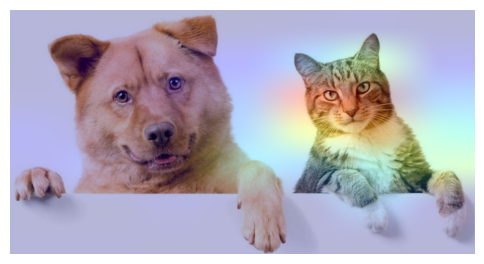

In [ ]:
# Cell
#We generate class activation heatmap for "cat" the class index is 285
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)

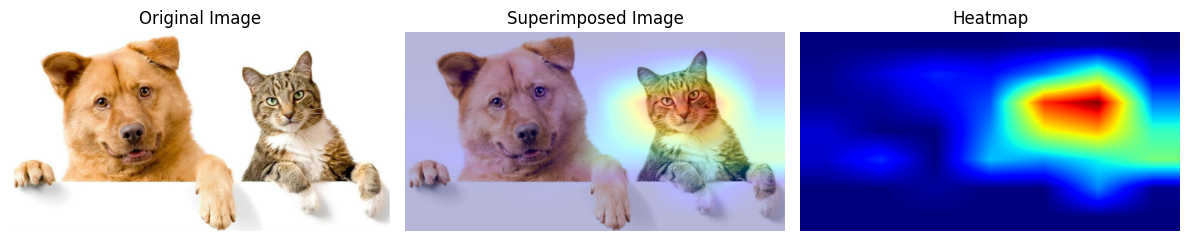

In [ ]:
# Cell
import cv2  # Ensure OpenCV is imported

def display_all_images(img_path, heatmap):
    # Load original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rescaled = np.uint8(255 * heatmap_resized)

    # Apply colormap for Grad-CAM
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]  # Get RGB values
    jet_heatmap = jet_colors[heatmap_rescaled]  # Map heatmap to jet colors

    # Convert to image
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Ensure saliency map is also resized to original image size
    saliency_map_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Match original image size
    saliency_map_rescaled = np.uint8(255 * saliency_map_resized)

    # Apply colormap for saliency map
    jet_saliency = jet_colors[saliency_map_rescaled]  # Map heatmap to jet colors
    jet_saliency_img = keras.utils.array_to_img(jet_saliency)

    # Display all images side by side
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(keras.utils.array_to_img(img))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(superimposed_img)
    axes[1].set_title("Superimposed Image")
    axes[1].axis("off")

    axes[2].imshow(jet_saliency_img)
    axes[2].set_title("Heatmap")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function to display all images
display_all_images(img_path, heatmap)


In [ ]:
# Cell
import os
import numpy as np
from scipy.ndimage import rotate
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

def rotate_image(img_path, angle, save_dir="rotated_images"):
    # Load and convert image
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Rotate image (keeping the size unchanged)
    rotated_array = rotate(img_array, angle, reshape=False)

    # Convert back to image
    rotated_img = array_to_img(rotated_array)

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save rotated image
    save_path = os.path.join(save_dir, f"rotated_{angle}.jpg")
    rotated_img.save(save_path)

    return rotated_img, save_path  # Return rotated image and its saved file path


In [ ]:
# Cell 14
rotation_angles = np.arange(-180, 181, 30)  # Angles from -180° to 180° in steps of 30°
rotated_images = []  # List to store (angle, rotated image, rotated path)

# Rotate image for each angle and save it
for angle in rotation_angles:
    rotated_img, rotated_img_path = rotate_image(img_path, angle)
    rotated_images.append((angle, rotated_img, rotated_img_path))

print(f"Generated {len(rotated_images)} rotated images.")


Generated 13 rotated images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


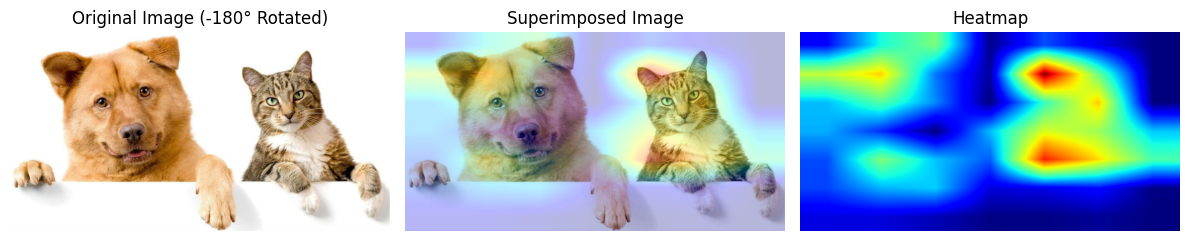

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


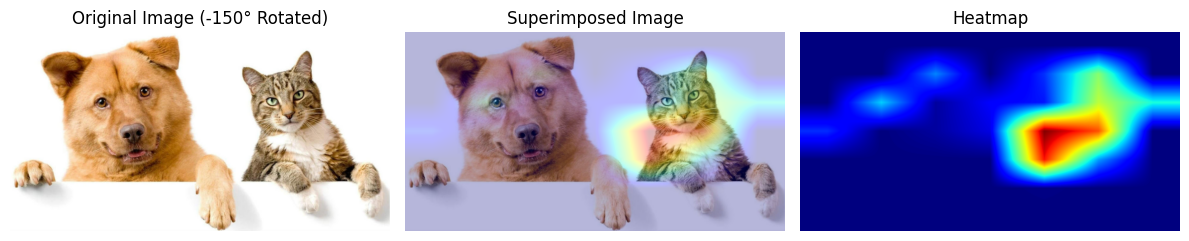

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


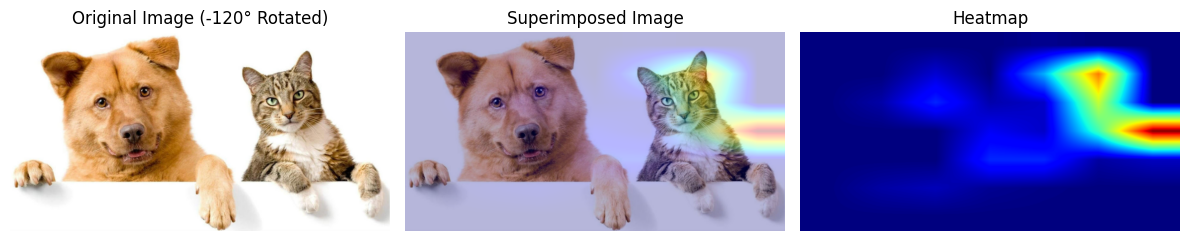

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


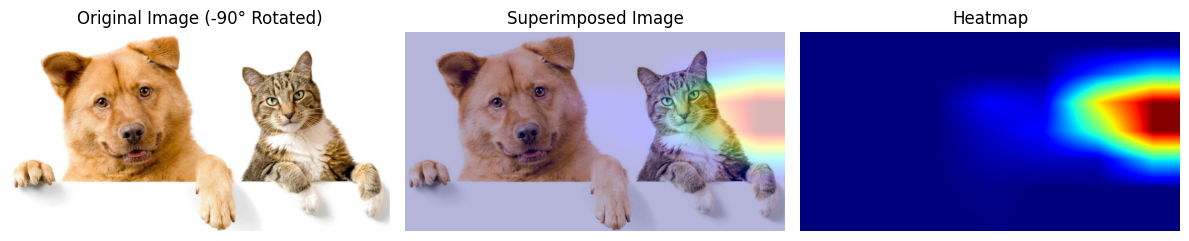

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


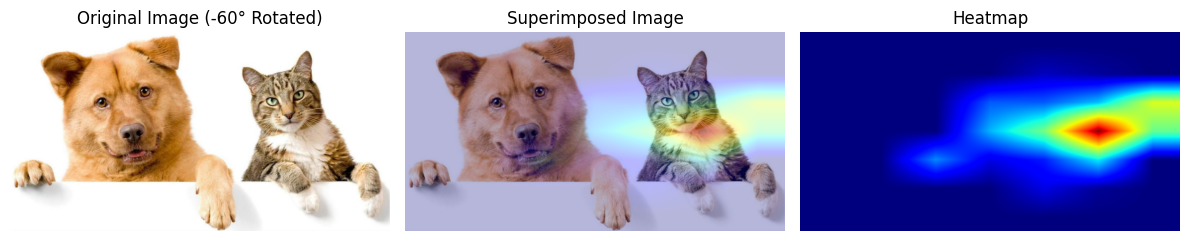

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


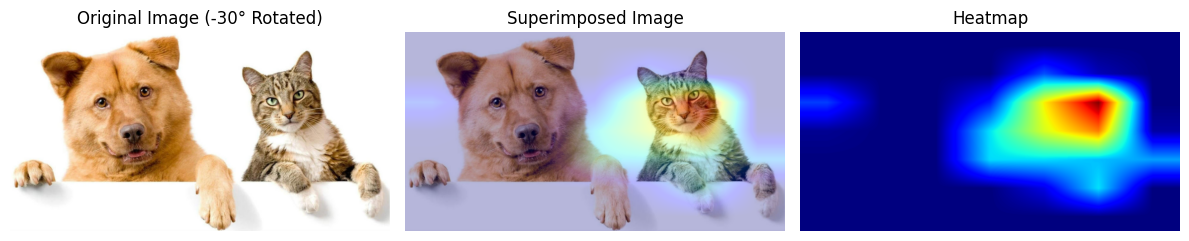

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


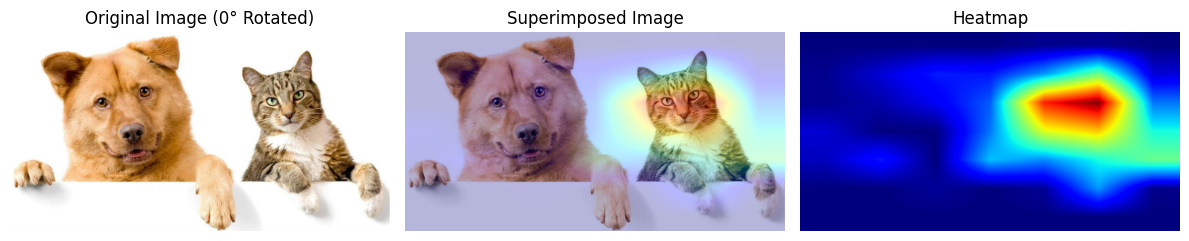

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


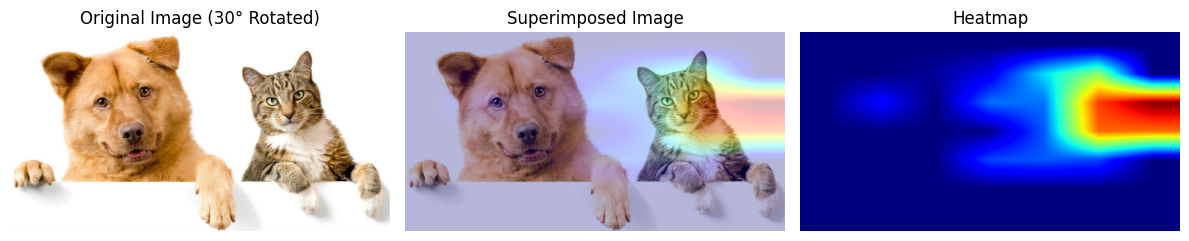

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


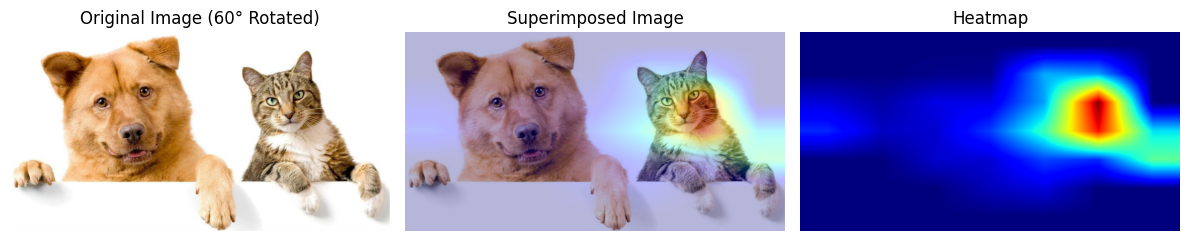

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


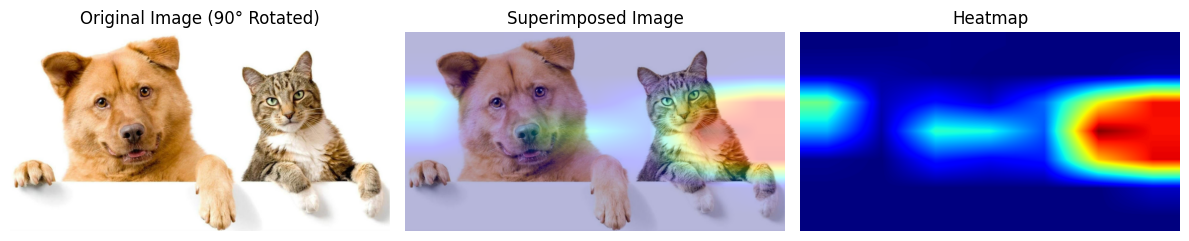

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


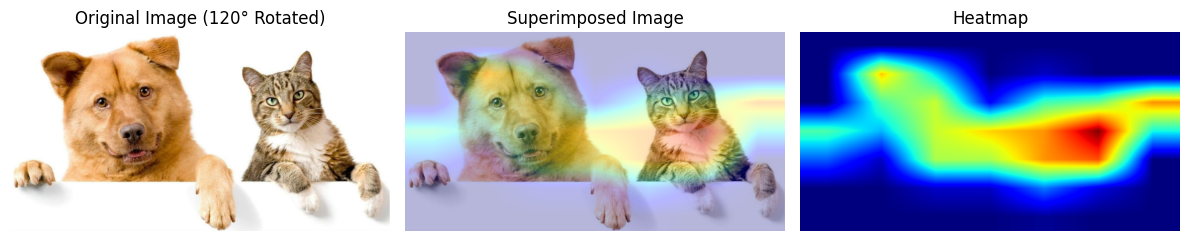

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


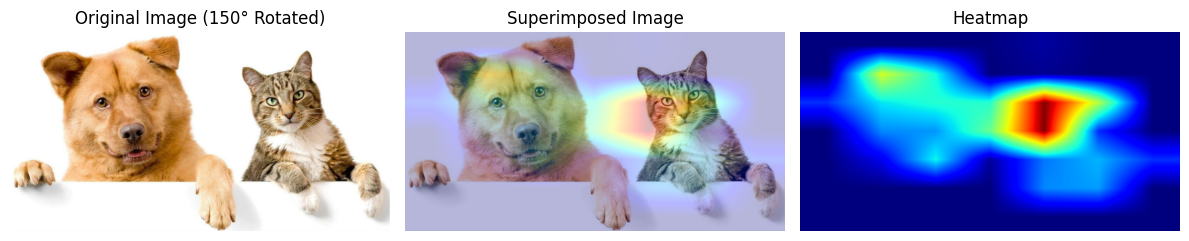

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


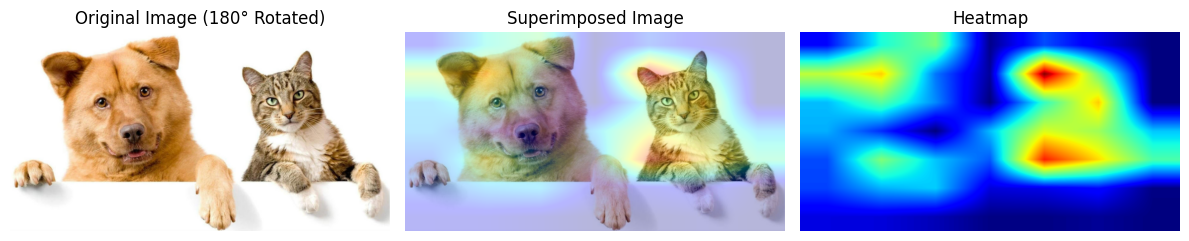

In [ ]:
# Cell
import cv2
from scipy.ndimage import rotate as scipy_rotate, gaussian_filter

def display_all_rotated_images(rotated_images):
    for angle, _, rotated_img_path in rotated_images:
        # Load and preprocess the rotated image
        rotated_img_array = preprocess_input(get_img_array(rotated_img_path, size=img_size))

        # Generate predictions
        preds = model.predict(rotated_img_array)
        pred_class = 285  # Get predicted class

        # Generate Grad-CAM heatmap for the predicted class
        heatmap = make_gradcam_heatmap(rotated_img_array, model, last_conv_layer_name, pred_index=pred_class)

        # Rotate the heatmap back to align with the original image
        aligned_heatmap = scipy_rotate(heatmap, -angle, reshape=False, order=0)  # Nearest-neighbor interpolation

        # Clip and normalize the heatmap
        aligned_heatmap = np.maximum(aligned_heatmap, 0)  # Remove negative values
        aligned_heatmap /= np.max(aligned_heatmap) if np.max(aligned_heatmap) > 0 else 1  # Normalize

        # Load original image
        img = keras.utils.load_img(img_path)
        img = keras.utils.img_to_array(img)

        # Resize heatmap to match image size
        heatmap_resized = cv2.resize(aligned_heatmap, (img.shape[1], img.shape[0]))
        heatmap_rescaled = np.uint8(255 * heatmap_resized)

        # Apply colormap for Grad-CAM
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]  # Get RGB values
        jet_heatmap = jet_colors[heatmap_rescaled]  # Map heatmap to jet colors

        # Convert to image
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        # Superimpose heatmap on original image
        superimposed_img = jet_heatmap * 0.4 + img
        superimposed_img = keras.utils.array_to_img(superimposed_img)

        # Ensure saliency map is also resized to original image size
        saliency_map_resized = cv2.resize(aligned_heatmap, (img.shape[1], img.shape[0]))  # Match original image size
        saliency_map_rescaled = np.uint8(255 * saliency_map_resized)

        # Apply colormap for saliency map
        jet_saliency = jet_colors[saliency_map_rescaled]  # Map heatmap to jet colors
        jet_saliency_img = keras.utils.array_to_img(jet_saliency)

        # Display all images side by side
        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(keras.utils.array_to_img(img))
        axes[0].set_title(f"Original Image ({angle}° Rotated)")
        axes[0].axis("off")

        axes[1].imshow(superimposed_img)
        axes[1].set_title("Superimposed Image")
        axes[1].axis("off")

        axes[2].imshow(jet_saliency_img)
        axes[2].set_title("Heatmap")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Call function to display all rotated images with heatmaps
display_all_rotated_images(rotated_images)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


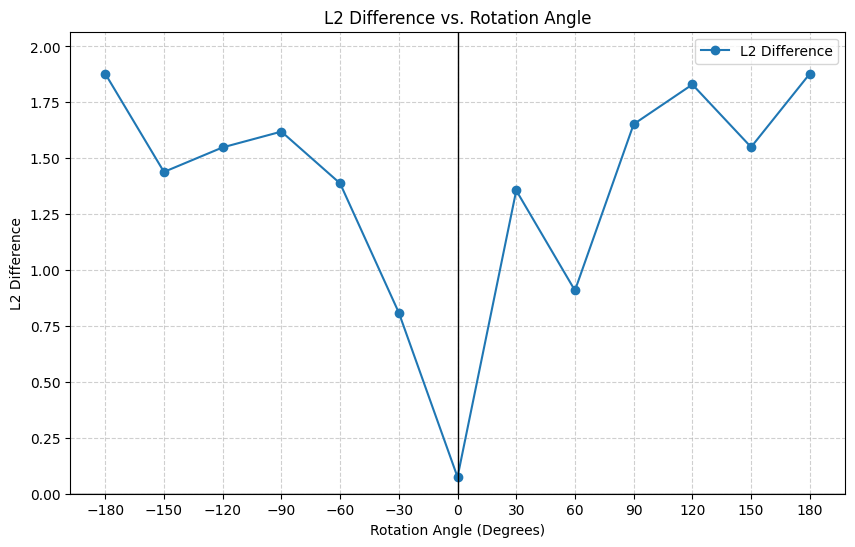

In [ ]:
# Cell
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Take the original heatmap (0-degree rotation) as the baseline
original_heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)  # Horig

# Step 2 & 3: Compute L2 Difference for each rotated heatmap
l2_differences = []
angles = []

for angle, _, rotated_img_path in rotated_images:
    # Load and preprocess the rotated image
    rotated_img_array = preprocess_input(get_img_array(rotated_img_path, size=img_size))

    # Generate Grad-CAM heatmap for the predicted class
    preds = model.predict(rotated_img_array)
    pred_class = 285  # Get predicted class
    rotated_heatmap = make_gradcam_heatmap(rotated_img_array, model, last_conv_layer_name, pred_index=pred_class)

    # Align rotated heatmap back to original orientation
    aligned_heatmap = scipy_rotate(rotated_heatmap, -angle, reshape=False, order=0)

    # Compute L2 difference (Euclidean distance)
    l2_diff = np.linalg.norm(original_heatmap - aligned_heatmap)
    l2_differences.append(l2_diff)
    angles.append(angle)




# Step 5: Visualize Results - L2 Difference vs Rotation Angle
plt.figure(figsize=(10, 6))
plt.plot(angles, l2_differences, marker='o', linestyle='-', label='L2 Difference')



# Fix X-axis to be centered at 0 and Y-axis starting from zero
plt.xlabel("Rotation Angle (Degrees)")
plt.ylabel("L2 Difference")
plt.title("L2 Difference vs. Rotation Angle")
plt.xticks(np.arange(min(angles), max(angles)+1, 30))  # Keep angles consistent
#plt.yticks(np.linspace(0, max(l2_differences) * 1.1, 10))  # Ensure Y-axis starts at 0
plt.ylim(0, max(l2_differences) * 1.1)  # Ensure Y-axis starts at 0
plt.axhline(y=0, color='black', linewidth=1)  # Ground Y-axis at 0
plt.axvline(x=0, color='black', linewidth=1)  # Ground X-axis at 0
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


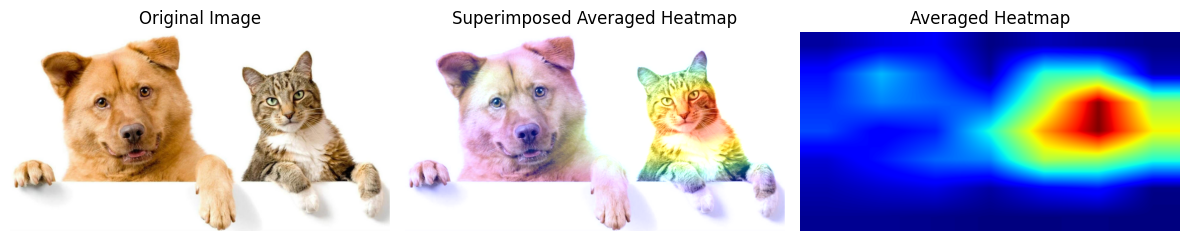

In [ ]:
# Cell
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from scipy.ndimage import rotate as scipy_rotate

def average_heatmaps_and_apply(rotated_images, img_path):
    # Load original image
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Initialize accumulator for heatmaps (same size as input image)
    heatmap_accum = np.zeros((img_size[0], img_size[1]), dtype=np.float32)

    count = 0  # Track number of heatmaps

    for angle, _, rotated_img_path in rotated_images:
        # Load and preprocess rotated image
        rotated_img_array = preprocess_input(get_img_array(rotated_img_path, size=img_size))

        # Generate predictions
        preds = model.predict(rotated_img_array)
        pred_class = 285  # Get predicted class

        # Generate Grad-CAM heatmap (small size, e.g., 7x7)
        heatmap = make_gradcam_heatmap(rotated_img_array, model, last_conv_layer_name, pred_index=pred_class)

        # Rotate heatmap back to align with the original image
        aligned_heatmap = scipy_rotate(heatmap, -angle, reshape=False, order=0)

        # **Fix: Resize heatmap to match (224, 224)**
        aligned_heatmap_resized = cv2.resize(aligned_heatmap, (img_size[1], img_size[0]))

        # Normalize heatmap
        aligned_heatmap_resized = np.maximum(aligned_heatmap_resized, 0)
        aligned_heatmap_resized /= np.max(aligned_heatmap_resized) if np.max(aligned_heatmap_resized) > 0 else 1

        # Accumulate heatmap
        heatmap_accum += aligned_heatmap_resized
        count += 1

    # Compute average heatmap
    average_heatmap = heatmap_accum / count
    average_heatmap /= np.max(average_heatmap) if np.max(average_heatmap) > 0 else 1  # Normalize again

    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(average_heatmap, (img_array.shape[1], img_array.shape[0]))

    # Apply colormap
    heatmap_rescaled = np.uint8(255 * heatmap_resized)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_rescaled]

    # Convert to image
    jet_heatmap = img_to_array(array_to_img(jet_heatmap))

    # Superimpose averaged heatmap on original image
    superimposed_img = (jet_heatmap * 0.4) + img_array
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(array_to_img(img_array))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(array_to_img(superimposed_img))
    axes[1].set_title("Superimposed Averaged Heatmap")
    axes[1].axis("off")

    axes[2].imshow(array_to_img(jet_heatmap))
    axes[2].set_title("Averaged Heatmap")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function to process and display the averaged heatmap
average_heatmaps_and_apply(rotated_images, img_path)
